# Computer Vision을 위한 전이학습

cs231n의 노트를 인용하면 실제로 충분학 크기의 데이터셋을 확보하는것이 힘들기 때문에, 처음부터 합성곱 신경망(Convolutional Network)를 학습 하는 경우가 드물다. 그래서 대용량의 데이터셋에서의 합성곱 신경망을 미리 학습하고 이것을 활용하여 관심있는 작업을 위한 초기설정 및 고정된 feature extractor로 사용한다. 

전이학습의 대표적인 2가지 시나리오 

- Finetuning: 무작위 초기화가 아닌 신경망을 ImageNet1000 데이터로 미리 학습한 신경망으로 초기화한다. 나머지 과정들은 동일

- Fixed Feature Extractor로 ConvNet 구성: 마지막 Fully Connected layer를 제외한 나머지 모든 신경망의 가중치를 고정한다. 그리고 마지막 Fully Connected layer를 새로운 임의의 가중치를 갖는 layer로 대체하여 이 layer를 학습한다. 
    

In [1]:
from __future__ import  print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np 
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os
import copy

plt.ion()  

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 불러오기 
torchvison과 torch.utils.data 패키지 사용 
개미와 벌 데이터셋 활용.
- training data: 120 ,validation data: 75 -> Normalize하기 힘든 작은 데이터셋이지만 전이학습을 통해 문제 극복
        

In [5]:
#학습을 위한 data augmentation & normalization
data_transforms = { 
'train' : transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
]),
'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
 }

data_dir = 'drive/MyDrive/Colab Notebooks/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                 for x in['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = { x :len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 일부 이미지 시각화하기 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


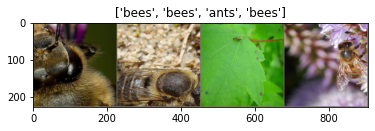

In [18]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std* inp +mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 모델 학습하기

- learing rate scheduler 설정 
- 모델 최적화

여기서 scheduler 매개변수는 torch.optim.lr_scheduler의 LR schduler 객체이다.

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 epoch는 학습단계과 검증단계를 거침
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # 데이터 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # parameter 기울기를 0으로 설정 
                optimizer.zero_grad()

                # forward pass 
                # 학습시에만 연산 기록추적 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습단계인 경우 backward pass + optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() + inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 deep copy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 가장 나을 모델 가중치를 불러옴 
    model.load_state_dict(best_model_wts)
    return model

## 모델 예측값 시각화 하기

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate (dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1 
                ax = plt.subplot(num_images //2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

    model.train(mode=was_training)                
        

## Finetuning

미리 학습한 모델을 불러온 후 마지막 FC layer를 초기화 한다.


In [29]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# 출력샘플의 크기는 2로 설정 
# 또는 nn.Linaer(num_ftrs, len(class_names0))로 일반화 가능하다.

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모드파라미터가 최적화 되는지 관찰 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7epoch마다 0.1씩 LR 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## Finetuning 학습 및 평가하기

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6493 Acc: 0.7008
val Loss: 0.2103 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4787 Acc: 0.8033
val Loss: 0.2652 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4117 Acc: 0.8648
val Loss: 0.2286 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5654 Acc: 0.7869
val Loss: 0.2759 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4749 Acc: 0.7992
val Loss: 0.3118 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.7204 Acc: 0.8033
val Loss: 0.6795 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.5037 Acc: 0.8361
val Loss: 0.3498 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.5178 Acc: 0.8320
val Loss: 0.2328 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3933 Acc: 0.8607
val Loss: 0.1991 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2666 Acc: 0.8811
val Loss: 0.2111 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3365 Acc: 0.8770
val Loss: 0.1993 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2993 Acc: 0.8730
val Loss: 0.1967 Acc: 0.9216

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


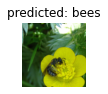

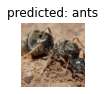

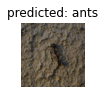

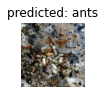

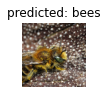

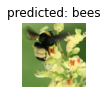

In [33]:
visualize_model(model_ft)


## Fixed Feature Extractor

마지막 FC layer를 제외한 신경망의 모든 부분을 고정해야한다
requires_grad = False로 설정하여 파라미터를 고정해서 backward() 중에 기울기가 계산되지 않도록 설정 해야한다. 


In [34]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 default가 requires_grad=True 이다.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Finetuning과 다른게 마지막 FC Layer의 파라미터만 최적화 되는지 관찰 
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7epoch마다 0.1씩 LR 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)



## 학습 및 평가하기

In [51]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.0580 Acc: 0.9016
val Loss: 1.0418 Acc: 0.9281

Epoch 1/24
----------
train Loss: 1.0857 Acc: 0.8566
val Loss: 1.0402 Acc: 0.9542

Epoch 2/24
----------
train Loss: 1.0774 Acc: 0.8770
val Loss: 1.0431 Acc: 0.9542

Epoch 3/24
----------
train Loss: 1.0872 Acc: 0.8443
val Loss: 1.0403 Acc: 0.9477

Epoch 4/24
----------
train Loss: 1.0931 Acc: 0.8156
val Loss: 1.0432 Acc: 0.9477

Epoch 5/24
----------
train Loss: 1.0861 Acc: 0.8525
val Loss: 1.0420 Acc: 0.9346

Epoch 6/24
----------
train Loss: 1.0902 Acc: 0.8484
val Loss: 1.0399 Acc: 0.9412

Epoch 7/24
----------
train Loss: 1.0701 Acc: 0.8607
val Loss: 1.0438 Acc: 0.9477

Epoch 8/24
----------
train Loss: 1.0857 Acc: 0.8320
val Loss: 1.0385 Acc: 0.9608

Epoch 9/24
----------
train Loss: 1.0895 Acc: 0.8197
val Loss: 1.0420 Acc: 0.9477

Epoch 10/24
----------
train Loss: 1.1193 Acc: 0.7910
val Loss: 1.0404 Acc: 0.9477

Epoch 11/24
----------
train Loss: 1.0899 Acc: 0.8484
val Loss: 1.0429 Acc: 0.9412

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


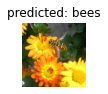

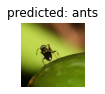

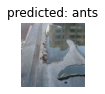

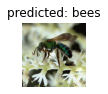

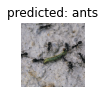

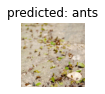

In [37]:
visualize_model(model_conv)

plt.ioff()
plt.show()